

---



# Sugarcane Leaf Disease Detection
The model is capable of performing Image Classification for:
1.   Healthy
2.   Red Rot
1.   Bacterial Blight

**Dataset:**<br>
*Healthy leaves: 100 Images*<br>
*Red Rot leaves: 100 Images*<br>
*Bacterial Blight leaves: 100 Images*<br>
*Total Images: 300 Images*


---






In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### Importing Libraries

In [ ]:
#Data Visualization
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import seaborn as sns

#Sharpening of images
from skimage.io import imshow, imread
from skimage.color import rgb2yuv, rgb2hsv, rgb2gray, yuv2rgb, hsv2rgb
from scipy.signal import convolve2d

#Preprocessing of Images
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

#Buliding Model
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

#Accuracy
from sklearn.metrics import classification_report

In [ ]:
data_dir = '/content/drive/MyDrive/NewData'
categories = os.listdir(data_dir)

In [ ]:
print(categories)

['Healthy', 'RedRot', 'BacterialBlight']


In [ ]:
labels=[i for i in range(len(categories))]
labels

[0, 1, 2]

#### Making a dictionary with Classes as Keys and Indices as Values

In [ ]:
label_dict=dict(zip(categories, labels))
label_dict

{'Healthy': 0, 'RedRot': 1, 'BacterialBlight': 2}

In [ ]:
data_list=[] #data_list- storing the images
labels_list=[] #label_list - storing the class labels

In [ ]:
data1="/content/drive/MyDrive/NewData/Healthy"
data2="/content/drive/MyDrive/NewData/RedRot"
data3="/content/drive/MyDrive/NewData/BacterialBlight"
count_healthy=0
count_redrot=0
count_bacterialblight=0

In [ ]:
for i in os.listdir(data1):
        img_path=os.path.join(data1, i)
        count_healthy=count_healthy+1

In [ ]:
for i in os.listdir(data2):
        img_path=os.path.join(data2, i)
        count_redrot=count_redrot+1

In [ ]:
for i in os.listdir(data3):
        img_path=os.path.join(data3, i)
        count_bacterialblight=count_bacterialblight+1

In [ ]:
count_healthy,count_redrot,count_bacterialblight

(100, 100, 100)

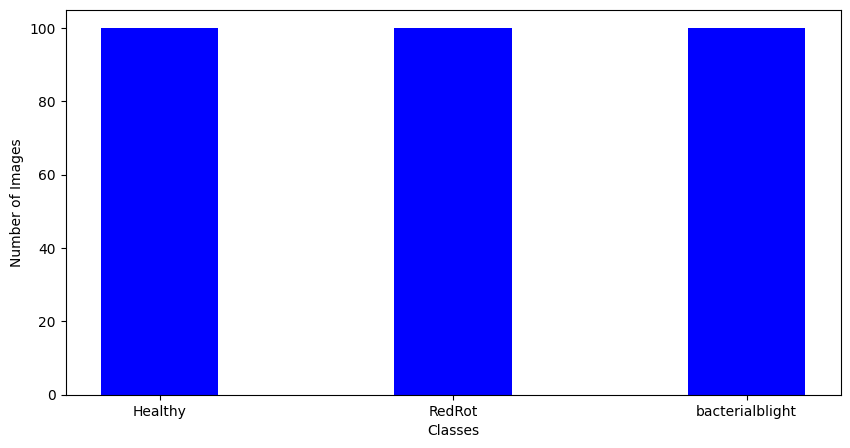

In [ ]:
fig = plt.figure(figsize = (10, 5))
classes=["Healthy","RedRot", "bacterialblight"]
values=[count_healthy,count_redrot,count_bacterialblight]
#creating the bar plot
plt.bar(classes, values, color ='blue',
        width = 0.4)

plt.xlabel("Classes")
plt.ylabel("Number of Images")
plt.show()

#### Defining a Sharpen Filter

In [ ]:
sharpen = np.array([[0, -1, 0],
                    [-1, 5, -1],
                    [0, -1, 0]])

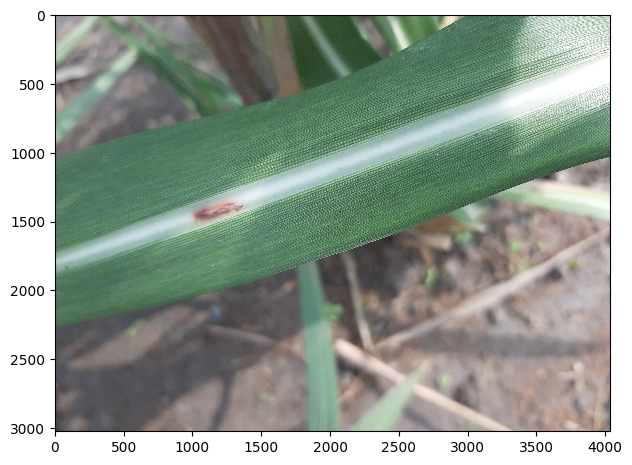

In [ ]:
og_image = imread(data_dir+'/RedRot/S_RR (1).jpg')
imshow(og_image);

In [ ]:
def multi_convolver(image, kernel, iterations):
    for i in range(iterations):
        image = convolve2d(image, kernel, 'same', boundary = 'fill',
                           fillvalue = 0)
    return image

In [ ]:
def convolver_rgb(image, kernel, iterations = 1):
    img_yuv = rgb2yuv(image)
    img_yuv[:,:,0] = multi_convolver(img_yuv[:,:,0], kernel,
                                     iterations)
    final_image = yuv2rgb(img_yuv)
    return final_image

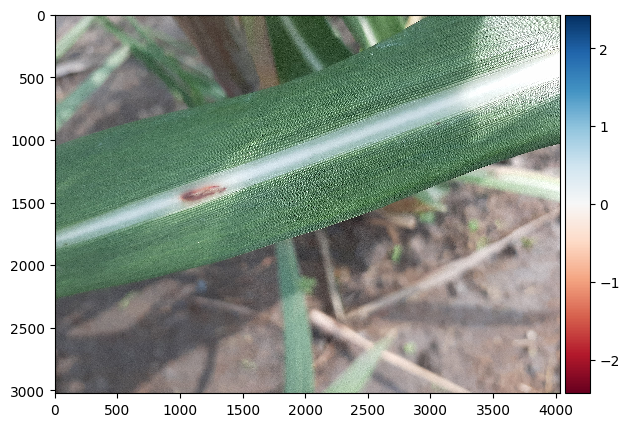

In [ ]:
final_image = convolver_rgb(og_image, sharpen, iterations = 1)
imshow(final_image);

#### Image Preprocessing
1.   Resizing to 224,224
2.   Sharpening



In [ ]:
from PIL import Image
for i in categories:
    folder_path=os.path.join(data_dir, i) #path to each disease folder
    img_names=os.listdir(folder_path)   #all images in each disease folder
    for img_name in img_names:
        img_path=os.path.join(folder_path, img_name)
        if(img_path=='/content/data/RedRot_copy/.DS_Store' or img_path=='/content/data/Healthy_copy/.DS_Store' or img_path=='/content/data/bacterialblight_copy/.DS_Store'):
          continue
        img = Image.open(img_path)
        img = img.resize((224,224))
        img = np.array(img)
        img = convolver_rgb(img, sharpen, iterations = 1)
        data_list.append(img)
        labels_list.append(label_dict[i])

In [ ]:
data_list[0].shape

(224, 224, 3)

In [ ]:
lb = LabelEncoder()
labels_list = lb.fit_transform(labels_list)
labels_list = to_categorical(labels_list)

In [ ]:
data = np.array(data_list)
labels = np.array(labels_list)
print("Done")
print(data.shape)

Done
(300, 224, 224, 3)


#### Visualizing Images in the Dataset after Preprocessing

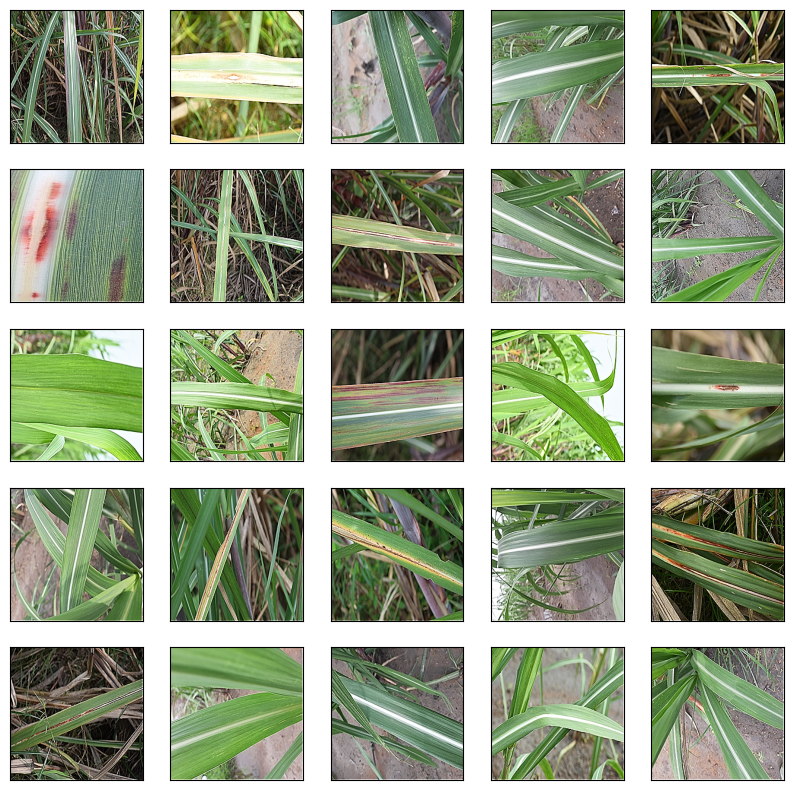

In [ ]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(data[np.random.randint(224)], cmap=plt.cm.binary)

plt.show()

#### Image Augmentation

In [ ]:
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

#### Splitting Dataset into Train and Test Sets

In [ ]:
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.20, stratify=labels, random_state=42)

In [ ]:
print( trainX.shape, testX.shape, trainY.shape, testY.shape)

(240, 224, 224, 3) (60, 224, 224, 3) (240, 3) (60, 3)


#### The model

In [ ]:
from keras.applications.densenet import DenseNet201
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Dense ,Dropout
from keras.layers import Input

In [ ]:
base_model = DenseNet201(include_top=False,
                         input_shape=(224,224,3),
                         weights='imagenet',
                         pooling="avg"
                     )

74836368/74836368 [==============================] - 0s 0us/step


In [ ]:
from tensorflow.keras.regularizers import l2

In [ ]:
base_model.trainable = False
image_input = Input(shape=(224, 224, 3))

x = base_model(image_input,training = False)

x = Dense(256,activation = "relu")(x)
x = Dropout(0.2)(x)

x = Dense(128,activation = "relu")(x)
x = Dropout(0.2)(x)

image_output = Dense(3,kernel_regularizer=l2(0.01),activation="softmax")(x) #output layer
#kernel Regulariser- SVM

model = Model(image_input,image_output)
model.compile(optimizer="adam",loss="squared_hinge",metrics=["accuracy"])
#loss function is square hinged- SVM

In [ ]:
from tensorflow.keras.utils import plot_model

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.4184 to fit



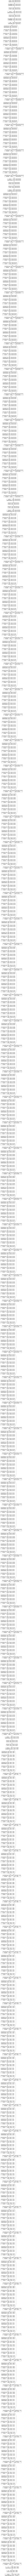

In [ ]:
plot_model(base_model, to_file = 'Densenet.png', show_shapes = True, show_layer_names = True)

#### Training the Model

In [ ]:
BS=32
EPOCHS=30

In [ ]:
history = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS)

Epoch 1/30
7/7 [==============================] - 37s 2s/step - loss: 1.3830 - accuracy: 0.3702 - val_loss: 1.1782 - val_accuracy: 0.7167
Epoch 2/30
7/7 [==============================] - 3s 404ms/step - loss: 1.2497 - accuracy: 0.5721 - val_loss: 1.0964 - val_accuracy: 0.7333
Epoch 3/30
7/7 [==============================] - 3s 391ms/step - loss: 1.0786 - accuracy: 0.7788 - val_loss: 1.0474 - val_accuracy: 0.7500
Epoch 4/30
7/7 [==============================] - 3s 428ms/step - loss: 1.0170 - accuracy: 0.7634 - val_loss: 1.0233 - val_accuracy: 0.7833
Epoch 5/30
7/7 [==============================] - 3s 400ms/step - loss: 0.9685 - accuracy: 0.7885 - val_loss: 1.0339 - val_accuracy: 0.7667
Epoch 6/30
7/7 [==============================] - 7s 873ms/step - loss: 0.9470 - accuracy: 0.8365 - val_loss: 0.9950 - val_accuracy: 0.7833
Epoch 7/30
7/7 [==============================] - 3s 407ms/step - loss: 0.9188 - accuracy: 0.8510 - val_loss: 1.0098 - val_accuracy: 0.7667
Epoch 8/30
7/7 [======

In [ ]:
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs))

[INFO] evaluating network...
2/2 [==============================] - 7s 4s/step
              precision    recall  f1-score   support

           0       0.95      0.90      0.92        20
           1       0.77      0.85      0.81        20
           2       0.84      0.80      0.82        20

    accuracy                           0.85        60
   macro avg       0.85      0.85      0.85        60
weighted avg       0.85      0.85      0.85        60



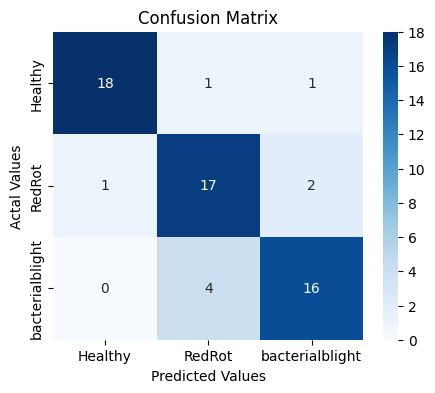

In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(testY.argmax(axis=1), predIdxs)


cm_df = pd.DataFrame(cm,
                     index = ['Healthy','RedRot','bacterialblight'],
                     columns = ['Healthy','RedRot','bacterialblight'])
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True, cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

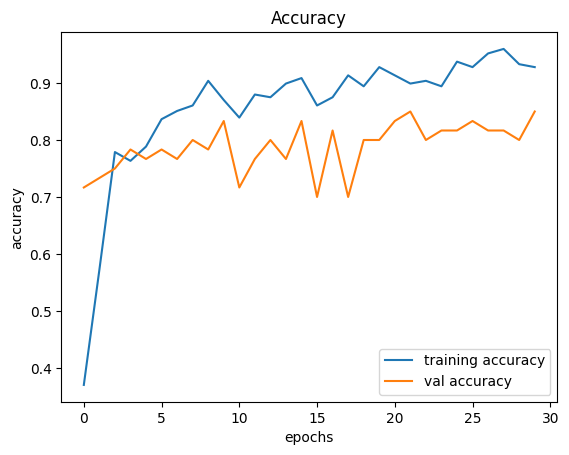

In [ ]:
import matplotlib.pyplot as plt
plt.figure(0)

plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()


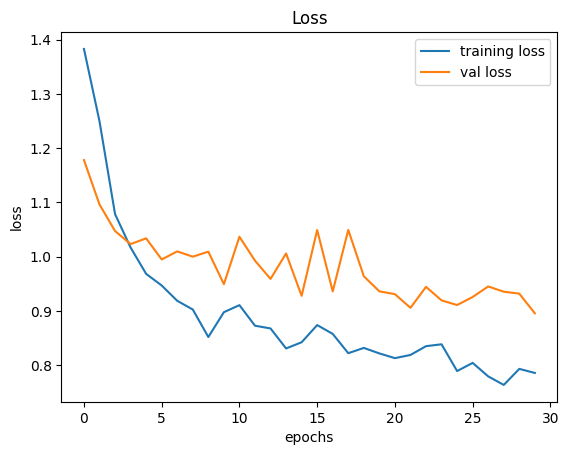

In [ ]:

plt.figure(1)
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

#### Making the Predictions

In [ ]:
from keras.preprocessing import image

img = image.load_img("/content/drive/MyDrive/test sugarcane disease/S_BLB (14).JPG", target_size=(224,224))
x = image.img_to_array(img)
x=x/255
img = convolver_rgb(img, sharpen, iterations = 1)
x=x.reshape(224,224,3)
x = np.expand_dims(x, axis=0)


predi=model.predict(x)
print(predi)
classes_x=np.argmax(predi)
print(classes_x)

classes=["Healthy","Red Rot", "Bacterial Blight"]
prediction_label=prediction_label=classes[classes_x]
if(prediction_label=="Healthy"):
  print("It is a Healthy Leaf")
else:
  print("Disease detected: "+prediction_label)

1/1 [==============================] - 2s 2s/step
[[4.2297778e-04 2.2822653e-03 9.9729472e-01]]
2
Disease detected: Bacterial Blight


#### Saving the Model

In [ ]:
model.save("sugarcane_model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
